# Import everything

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import sys
import types
import os
from pathlib import Path
try:
    import _dropbox_wrapper as dbw
except ImportError:
    dbw = None

# To run the interactive plot in cell 3, install this:
# conda install -c conda-forge ipympl ipywidgets
%matplotlib widget
# Works in Jupyter Notebook version 7.0.8
from IPython.display import display, HTML
display(HTML("<style>.jp-Cell { margin-left: -20% !important; margin-right: -15% !important; }</style>"))

# Load recovery

In [2]:
recovery_filename = '/Users/eitanturok/good-vibrations/data/vibrations/cube_pos1_29_12_Time_19_16_40/RECOVERY.npz'
cube_position = int(recovery_filename.split('/')[-2].lstrip('cube_pos')[0])
cube_position

1

In [3]:
# 0) Define your placeholder function exactly as pickle expects it
def compute_CAM2_translations_v3_cupy(*args, **kwargs):
    # either a no‑op or your real implementation
    return None

# 1) Inject (or patch) the recover_core_lib module *before* loading
if 'recover_core_lib' in sys.modules:
    # if it was already imported, just add the missing name
    sys.modules['recover_core_lib'].compute_CAM2_translations_v3_cupy = compute_CAM2_translations_v3_cupy
else:
    fake = types.ModuleType('recover_core_lib')
    fake.compute_CAM2_translations_v3_cupy = compute_CAM2_translations_v3_cupy
    sys.modules['recover_core_lib'] = fake

if not os.path.isfile(recovery_filename) and dbw is not None:
    recovery_data   = np.load(dbw.dbox_read_file(Path(recovery_filename).as_posix()), allow_pickle=True)
else:
    recovery_data   = np.load(recovery_filename, allow_pickle=True)

all_shifts        = recovery_data['all_shifts']
all_params        = recovery_data['all_params']
loaded_filename   = recovery_data['loaded_filename']
run_opt           = recovery_data['run_opt'].item()

print("Recovery file loaded successfully:")
print(" - File:", recovery_filename)
print(" - all_shifts shape:", all_shifts.shape)
print(" - all_params keys:", list(all_params.keys()) if isinstance(all_params, dict) else "Not a dict")
print(" - run_opt keys:", list(run_opt.keys()) if isinstance(run_opt, dict) else "Not a dict")
print(" - fs:", run_opt['cam_params']['camera_FPS'])
all_shifts=all_shifts[:,1:]

Recovery file loaded successfully:
 - File: /Users/eitanturok/good-vibrations/data/vibrations/cube_pos1_29_12_Time_19_16_40/RECOVERY.npz
 - all_shifts shape: (100, 30000, 2)
 - all_params keys: Not a dict
 - run_opt keys: ['cam_params', 'run_opt_multiROIs', 'run_opt_recovery', 'run_dict']
 - fs: 5000


In [4]:
all_shifts.shape

(100, 29999, 2)

# Visualize data

## Filter the signals

In [5]:
from scipy.signal import butter, sosfiltfilt

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter(order, [lowcut, highcut], fs=fs, btype='band', output='sos')
    return sosfiltfilt(sos, data)

fs = run_opt['cam_params']['camera_FPS']
lowcut = 50
highcut = fs//2 -1  # Must be < fs/2 (Nyquist frequency = 2500 Hz)
order = 5

if 1:
    filtered_shifts = np.empty_like(all_shifts)
    for i in range(all_shifts.shape[0]):
        for j in range(all_shifts.shape[2]):
            filtered_shifts[i, :, j] = bandpass_filter(all_shifts[i, :, j], lowcut, highcut, fs, order)
else:
    filtered_shifts = all_shifts

## Visualize

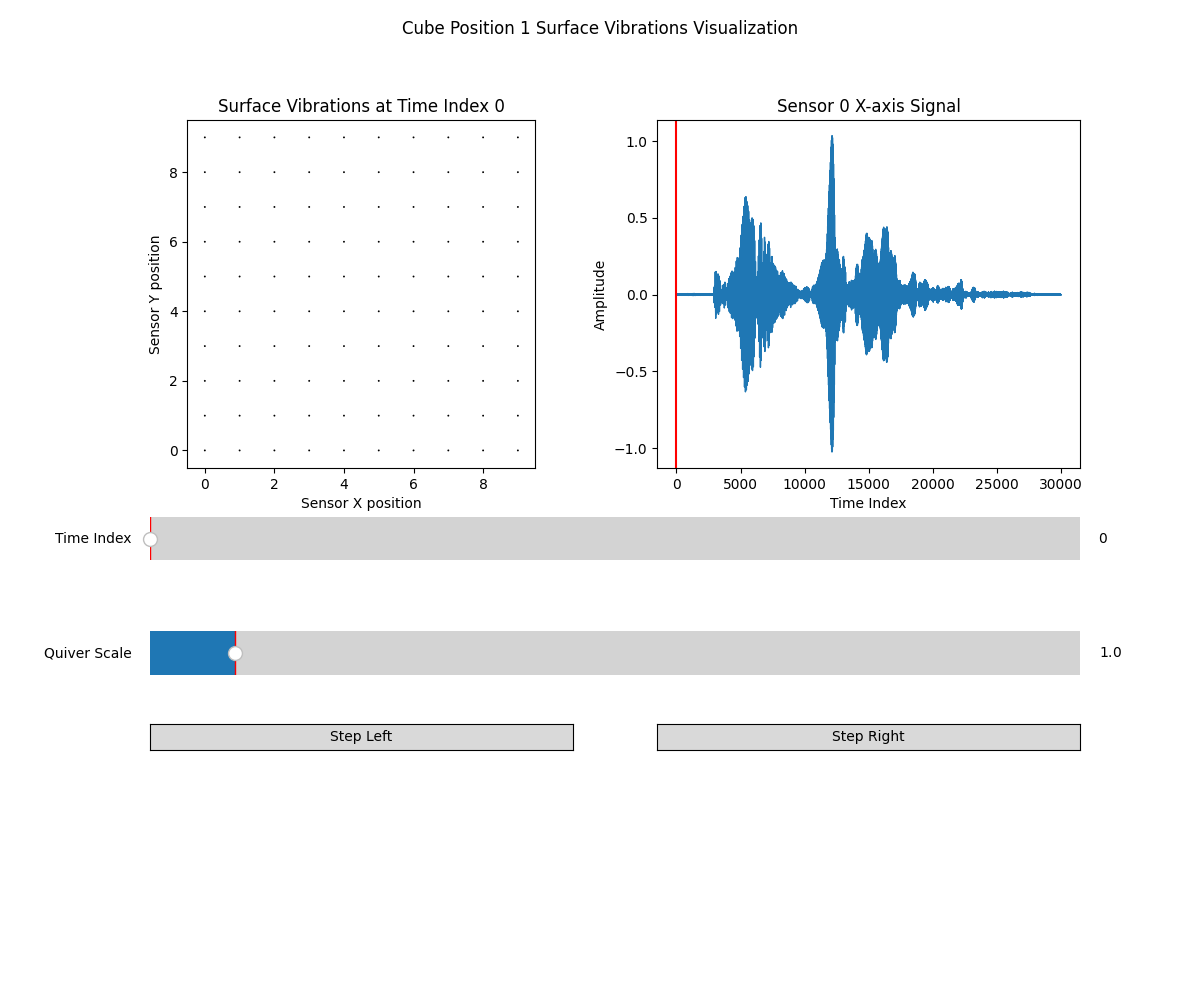

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import matplotlib.gridspec as gridspec

# =============================================================================
# Dummy data for demonstration.
# Assume a 6x6 grid of sensors (36 sensors total) and a time series of 5000 samples.
# Each sensor has two signals (e.g., x and y).
# Replace this with your actual data.
n_points = 10
sensors = n_points*n_points
show_sensors = []
# all_shifts should already be defined; for example purposes, you could create dummy data:
# all_shifts = np.random.randn(sensors, 5000, 2)

# =============================================================================

show_shifts = filtered_shifts#[:36]
time_steps = all_shifts.shape[1]

# Select visualization mode: "xy_phase" or "sig_zoom"
SHOW_VIS = "xy_phase"  # Change to "sig_zoom" to run the alternative visualization
show_pnt = 0
if SHOW_VIS == "xy_phase":
    # -------------------------------
    # Mode 1: XY Phase Visualization (with additional Quiver Scale slider)
    # -------------------------------
    x_coords, y_coords = np.meshgrid(np.arange(n_points), np.arange(n_points))

    # Create a gridspec layout with 4 rows:
    # Row 0: Main plots (quiver and signal)
    # Row 1: Time slider
    # Row 2: Scale slider
    # Row 3: Step Left/Right buttons
    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(4, 2, height_ratios=[4, 1, 1, 0.3])
    fig.suptitle(f"Cube Position {cube_position} Surface Vibrations Visualization")

    ax_quiver = fig.add_subplot(gs[0, 0])
    ax_signal = fig.add_subplot(gs[0, 1])
    ax_slider = fig.add_subplot(gs[1, :])
    ax_scale_slider = fig.add_subplot(gs[2, :])

    init_time = 0
    vectors = show_shifts[:, init_time, :].reshape(n_points, n_points, 2)
    U = vectors[:, :, 0]
    V = vectors[:, :, 1]
    # Create the initial quiver plot with a scale of 1.
    q = ax_quiver.quiver(x_coords, y_coords, U, V, pivot='tail', scale=1)
    ax_quiver.set_title(f"Surface Vibrations at Time Index {init_time}")
    ax_quiver.set_xlim(-0.5, n_points - 0.5)
    ax_quiver.set_ylim(-0.5, n_points - 0.5)
    ax_quiver.set_aspect('equal')
    ax_quiver.set_xlabel("Sensor X position")
    ax_quiver.set_ylabel("Sensor Y position")

    time_array = np.arange(time_steps)
    signal_ = show_shifts[0, :, 0]
    ax_signal.plot(time_array, signal_, lw=1)
    ax_signal.set_title("Sensor 0 X-axis Signal")
    ax_signal.set_xlabel("Time Index")
    ax_signal.set_ylabel("Amplitude")
    vline = ax_signal.axvline(init_time, color='red', lw=1.5)

    # Time slider
    slider = Slider(ax=ax_slider, label='Time Index',
                    valmin=0, valmax=time_steps - 1, valinit=init_time,
                    valfmt='%0.0f', valstep=1)

    # Quiver Scale slider
    scale_slider = Slider(ax=ax_scale_slider, label='Quiver Scale',
                          valmin=0.1, valmax=10, valinit=1, valstep=0.1)

    # Update function for time slider: update time and replot quiver with current scale.
    def update_time(val):
        global q
        t_index = int(slider.val)
        vline.set_xdata([t_index])
        vectors = show_shifts[:, t_index, :].reshape(n_points, n_points, 2)
        U = vectors[:, :, 0]
        V = vectors[:, :, 1]
        # Remove the old quiver and draw a new one with the current scale.
        q.remove()
        q = ax_quiver.quiver(x_coords, y_coords, U, V, pivot='tail', scale=scale_slider.val)
        ax_quiver.set_title(f"Surface Vibrations at Time Index {t_index}")
        fig.canvas.draw_idle()

    # Update function for scale slider: replot quiver with updated scale.
    def update_scale(val):
        global q
        t_index = int(slider.val)
        vectors = show_shifts[:, t_index, :].reshape(n_points, n_points, 2)
        U = vectors[:, :, 0]
        V = vectors[:, :, 1]
        q.remove()
        q = ax_quiver.quiver(x_coords, y_coords, U, V, pivot='tail', scale=scale_slider.val)
        fig.canvas.draw_idle()

    slider.on_changed(update_time)
    scale_slider.on_changed(update_scale)

    # Create buttons for stepping left/right.
    ax_button_left = fig.add_subplot(gs[3, 0])
    ax_button_right = fig.add_subplot(gs[3, 1])
    btn_left = Button(ax_button_left, 'Step Left')
    btn_right = Button(ax_button_right, 'Step Right')

    def step_left(event):
        current_val = int(slider.val)
        new_val = max(0, current_val - 1)
        slider.set_val(new_val)

    def step_right(event):
        current_val = int(slider.val)
        new_val = min(time_steps - 1, current_val + 1)
        slider.set_val(new_val)

    btn_left.on_clicked(step_left)
    btn_right.on_clicked(step_right)

    plt.subplots_adjust(bottom=0.25)
    plt.show()

elif SHOW_VIS == "sig_zoom":
    # -------------------------------------
    # Mode 2: Signal Zoom Visualization with Full Signal
    # (No additional buttons or scale slider)
    # -------------------------------------
    window_size = 1000
    half_window = window_size // 2

    def get_window_indices(t_index):
        start = max(0, t_index - half_window)
        end = min(time_steps, t_index + half_window)
        return start, end

    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(4, 1, height_ratios=[1.5, 3, 3, 1])

    # Row 0: Full signal for sensor 0 x-axis.
    ax_full = fig.add_subplot(gs[0])
    time_array = np.arange(time_steps)
    ax_full.plot(time_array, filtered_shifts[show_pnt, :, 0], lw=1)
    vline_full = ax_full.axvline(0, color='red', lw=1.5)
    ax_full.set_title("Full Signal of Sensor 0 (X-axis)")
    ax_full.set_xlabel("Time Index")
    ax_full.set_ylabel("Amplitude")

    # Rows 1 and 2: Zoomed signals for all sensors.
    ax_sig_x = fig.add_subplot(gs[1])
    ax_sig_y = fig.add_subplot(gs[2])

    init_time = 0
    start, end = get_window_indices(init_time)
    time_window = np.arange(start, end)

    for sensor in range(sensors):
        ax_sig_x.plot(time_window, filtered_shifts[sensor, start:end, 0], lw=1)
        ax_sig_y.plot(time_window, filtered_shifts[sensor, start:end, 1], lw=1)

    ax_sig_x.axvline(init_time, color='red', lw=1.5)
    ax_sig_y.axvline(init_time, color='red', lw=1.5)
    ax_sig_x.set_title("X-axis Signals (Zoomed)")
    ax_sig_x.set_ylabel("Amplitude")
    ax_sig_y.set_title("Y-axis Signals (Zoomed)")
    ax_sig_y.set_xlabel("Time Index")
    ax_sig_y.set_ylabel("Amplitude")

    # Row 3: Slider.
    ax_slider = fig.add_subplot(gs[3])
    slider = Slider(ax=ax_slider, label='Time Index',
                    valmin=0, valmax=time_steps - 1, valinit=init_time,
                    valfmt='%0.0f', valstep=1)

    def update(val):
        t_index = int(slider.val)
        vline_full.set_xdata([t_index])
        start, end = get_window_indices(t_index)
        time_window = np.arange(start, end)
        ax_sig_x.cla()
        ax_sig_y.cla()
        for sensor in range(sensors):
            ax_sig_x.plot(time_window, filtered_shifts[sensor, start:end, 0], lw=1)
            ax_sig_y.plot(time_window, filtered_shifts[sensor, start:end, 1], lw=1)
        ax_sig_x.axvline(t_index, color='red', lw=1.5)
        ax_sig_y.axvline(t_index, color='red', lw=1.5)
        ax_sig_x.set_title("X-axis Signals (Zoomed)")
        ax_sig_x.set_ylabel("Amplitude")
        ax_sig_y.set_title("Y-axis Signals (Zoomed)")
        ax_sig_y.set_xlabel("Time Index")
        ax_sig_y.set_ylabel("Amplitude")
        fig.canvas.draw_idle()

    slider.on_changed(update)

    plt.subplots_adjust(hspace=0.5, bottom=0.15)
    plt.show()


## Export video animation

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1800x900', '-pix_fmt', 'rgba', '-framerate', '60', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-b', '1800k', '-metadata', 'artist=matplotlib', '-y', 'xy_phase2.mp4']' returned non-zero exit status 255.

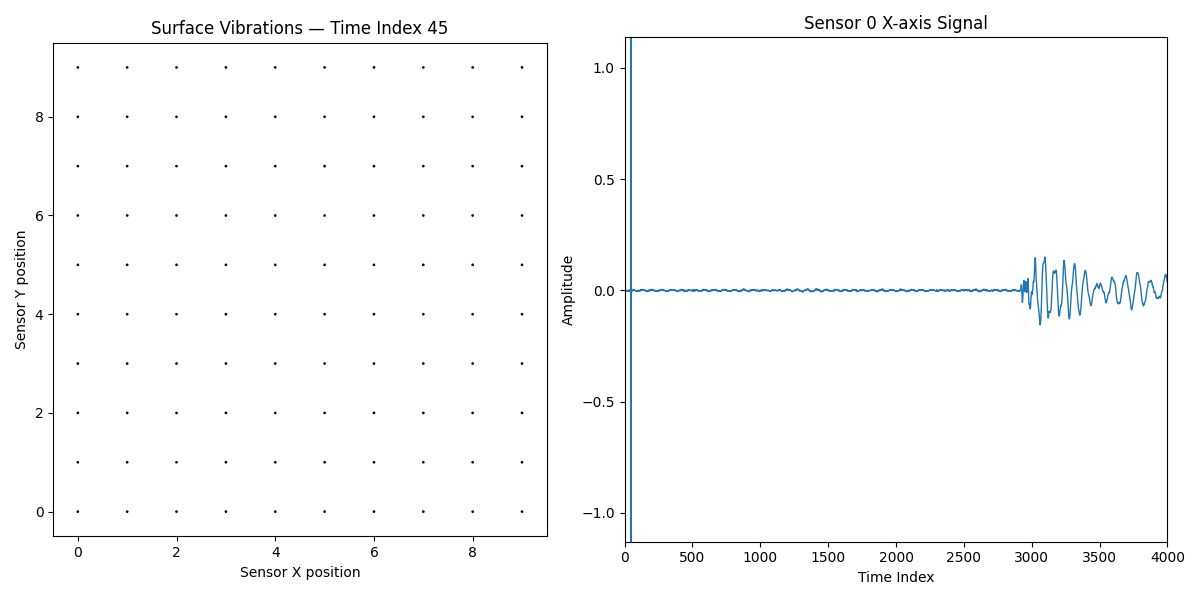

In [7]:
from matplotlib.animation import FFMpegWriter, PillowWriter

def make_xy_phase_video(
    show_shifts: np.ndarray,
    n_points: int,
    idx_start: int,
    idx_end: int,
    fps: int = 30,
    quiver_scale: float = 1.0,
    outfile: str = "xy_phase.mp4",
    dpi: int = 150,
    signal_sensor_index: int = 0,  # which sensor to show on the right panel
    signal_component: int = 0      # 0 = x component, 1 = y component
):
    """
    Save an XY-phase quiver animation to a video.

    Parameters
    ----------
    show_shifts : np.ndarray
        Array of shape (n_points*n_points, T, 2): per-sensor (x,y) shifts over time.
        Example from your code: show_shifts = filtered_shifts / 20
    n_points : int
        Grid size (e.g., 10 -> 10x10 sensors).
    idx_start : int
        First time index to include (inclusive).
    idx_end : int
        Last time index to include (inclusive).
    fps : int
        Frames per second for the output video.
    quiver_scale : float
        Constant scale used by matplotlib's quiver (same as interactive code, but fixed).
    outfile : str
        Output filename (e.g., "xy_phase.mp4" or "xy_phase.gif").
    dpi : int
        DPI for the saved video frames.
    signal_sensor_index : int
        Which sensor's signal to plot on the right panel (0 .. n_points*n_points-1).
    signal_component : int
        Which component (0 for x, 1 for y) to plot on the right panel.
    """

    sensors, T, comps = show_shifts.shape
    assert sensors == n_points * n_points, "show_shifts first dim must be n_points*n_points"
    assert comps == 2, "show_shifts last dim must have size 2 (x,y)"

    # Clamp the requested range to valid bounds
    idx_start = max(0, idx_start)
    idx_end = min(T - 1, idx_end)
    if idx_end < idx_start:
        raise ValueError("idx_end must be >= idx_start after clamping to data length.")

    # Grid coordinates
    x_coords, y_coords = np.meshgrid(np.arange(n_points), np.arange(n_points))

    # Figure layout: left = quiver, right = one sensor's signal with a moving time cursor
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.1])

    ax_quiver = fig.add_subplot(gs[0, 0])
    ax_signal = fig.add_subplot(gs[0, 1])

    # Initial frame
    t0 = idx_start
    vectors0 = show_shifts[:, t0, :].reshape(n_points, n_points, 2)
    U0 = vectors0[:, :, 0]
    V0 = vectors0[:, :, 1]

    q = ax_quiver.quiver(
        x_coords, y_coords, U0, V0,
        pivot='tail',
        scale=quiver_scale
    )
    ax_quiver.set_title(f"Surface Vibrations — Time Index {t0}")
    ax_quiver.set_xlim(-0.5, n_points - 0.5)
    ax_quiver.set_ylim(-0.5, n_points - 0.5)
    ax_quiver.set_aspect('equal')
    ax_quiver.set_xlabel("Sensor X position")
    ax_quiver.set_ylabel("Sensor Y position")

    # Right panel: show one sensor's component over the full requested time window
    time_array = np.arange(T)
    sig = show_shifts[signal_sensor_index, :, signal_component]
    ax_signal.plot(time_array, sig, lw=1)
    vline = ax_signal.axvline(t0, lw=1.5)
    comp_name = "X" if signal_component == 0 else "Y"
    ax_signal.set_title(f"Sensor {signal_sensor_index} {comp_name}-axis Signal")
    ax_signal.set_xlabel("Time Index")
    ax_signal.set_ylabel("Amplitude")
    ax_signal.set_xlim(idx_start, idx_end)

    fig.tight_layout()

    # Writer (FFmpeg preferred; fall back to Pillow if FFmpeg isn't available)
    writer = None
    if outfile.lower().endswith(".mp4"):
        try:
            writer = FFMpegWriter(fps=fps, metadata={"artist": "matplotlib"}, bitrate=1800)
        except Exception:
            raise RuntimeError(
                "FFmpeg is required to write MP4. Install FFmpeg or use a .gif outfile."
            )
    elif outfile.lower().endswith(".gif"):
        writer = PillowWriter(fps=fps)
    else:
        # default to mp4 with ffmpeg
        try:
            writer = FFMpegWriter(fps=fps, metadata={"artist": "matplotlib"}, bitrate=1800)
            if not outfile.lower().endswith(".mp4"):
                outfile = outfile + ".mp4"
        except Exception:
            writer = PillowWriter(fps=fps)
            if not outfile.lower().endswith(".gif"):
                outfile = outfile + ".gif"

    # Render frames
    with writer.saving(fig, outfile, dpi):
        for t in range(idx_start, idx_end + 1):
            # Update quiver vectors
            vectors = show_shifts[:, t, :].reshape(n_points, n_points, 2)
            U = vectors[:, :, 0]
            V = vectors[:, :, 1]
            # Update quiver in place (faster than recreating)
            q.set_UVC(U, V)

            # Update titles and time cursor
            ax_quiver.set_title(f"Surface Vibrations — Time Index {t}")
            vline.set_xdata([t])

            # Draw and capture the frame
            fig.canvas.draw()
            writer.grab_frame()

    plt.close(fig)
    print(f"Saved video to: {outfile}")


idx_start = 0
idx_end   = 4000
fps       = 60
quiver_scale = 15  # constant scale
make_xy_phase_video(show_shifts, n_points, idx_start, idx_end, fps, quiver_scale, outfile="xy_phase2.mp4")


# Show FFTs

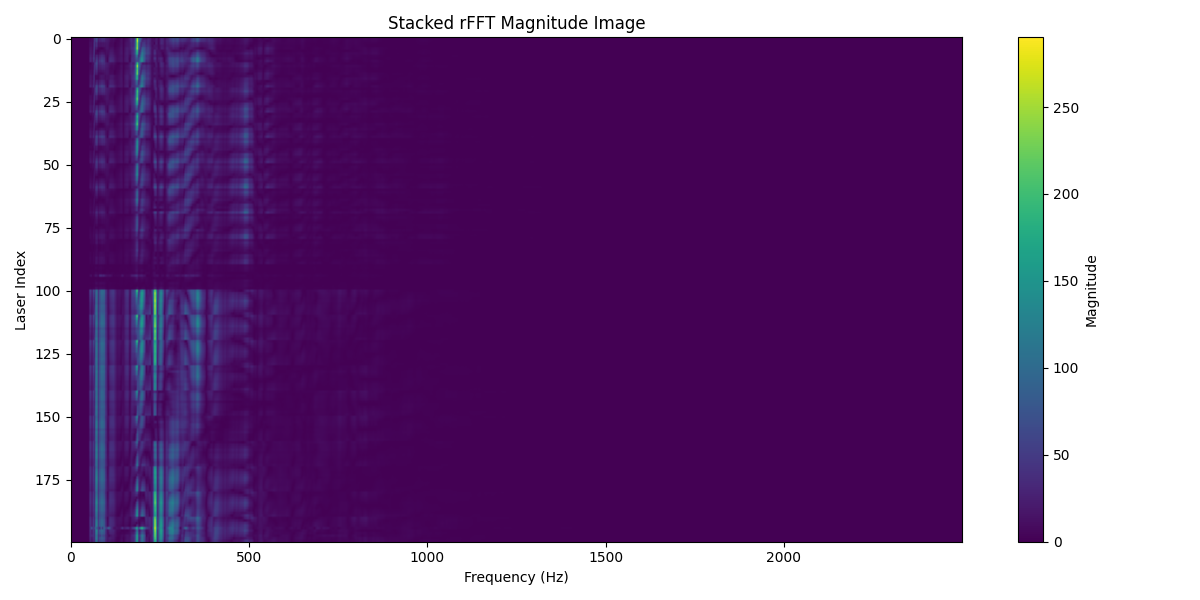

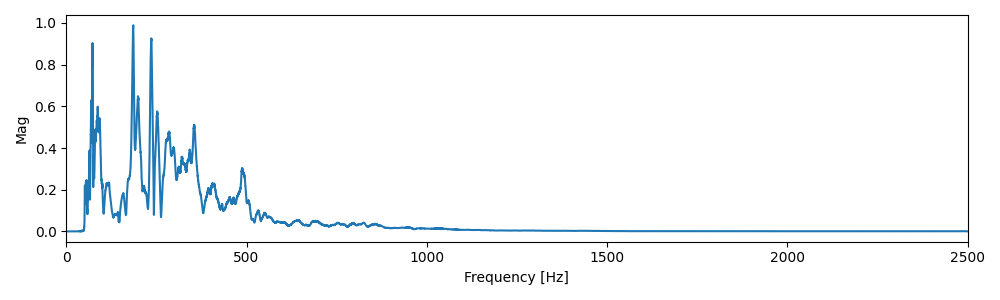

In [8]:
def plot_stacked_rfft_image(filtered_shifts, fs, use_window=True, db_scale=False,xlim = None):
    """
    filtered_shifts: np.ndarray of shape (36, 50000, 2)
    fs: sampling frequency (Hz)
    use_window: apply Hann window before FFT
    db_scale: show magnitude in dB (20*log10)
    """
    # Validate shapes
    assert filtered_shifts.ndim == 3 and filtered_shifts.shape[2] == 2, \
        "filtered_shifts must be (36, N, 2)"
    n_pts = filtered_shifts.shape[1]

    # Stack x first (dir=0) then y (dir=1) -> (72, N)
    sig_x = filtered_shifts[:, :, 0]
    sig_y = filtered_shifts[:, :, 1]
    signals = np.vstack([sig_x, sig_y])  # shape: (72, n_pts)

    # Optional window to reduce spectral leakage
    if use_window:
        window = np.hanning(n_pts)[None, :]  # broadcast across rows
        signals = signals * window

    # rFFT along time axis
    rfft_vals = np.fft.rfft(signals, axis=1)
    mag = np.abs(rfft_vals)  # shape: (72, n_freq_bins)

    # Optional dB scaling (add tiny epsilon to avoid log(0))
    if db_scale:
        mag = 20.0 * np.log10(np.maximum(mag, 1e-12))

    # Frequency axis
    freqs = np.fft.rfftfreq(n_pts, d=1.0 / fs)

    # Plot as a single image
    plt.figure(figsize=(12, 6))
    # extent: [x_min, x_max, y_min, y_max]; origin='upper' puts row 0 at top
    im = plt.imshow(
        mag,
        aspect='auto',
        origin='upper',
        extent=[freqs[0], freqs[-1], mag.shape[0] - 0.5, -0.5]
    )
    # Separator between x- and y-shift stacks
    #plt.axhline(35.5, color='white', linewidth=1)

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Laser Index")
    plt.title("Stacked rFFT Magnitude Image")
    cbar = plt.colorbar(im)
    cbar.set_label("Magnitude" + (" (dB)" if db_scale else ""))
    plt.tight_layout()
    plt.show()
    return mag, freqs

# Example usage:
mags, freqs = plot_stacked_rfft_image(filtered_shifts, fs, use_window=True, db_scale=False)

plt.figure(figsize=(10, 3))
# plt.plot(freqs, mags.std(axis=0)) I think mean over different laser indices is better
plt.plot(freqs, mags.mean(axis=0) / sensors)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Mag')
plt.xlim([0,2500])
plt.tight_layout()

# Show mode from FFT

Closest frequency: 236.174539151305 Hz (index: 1417 )


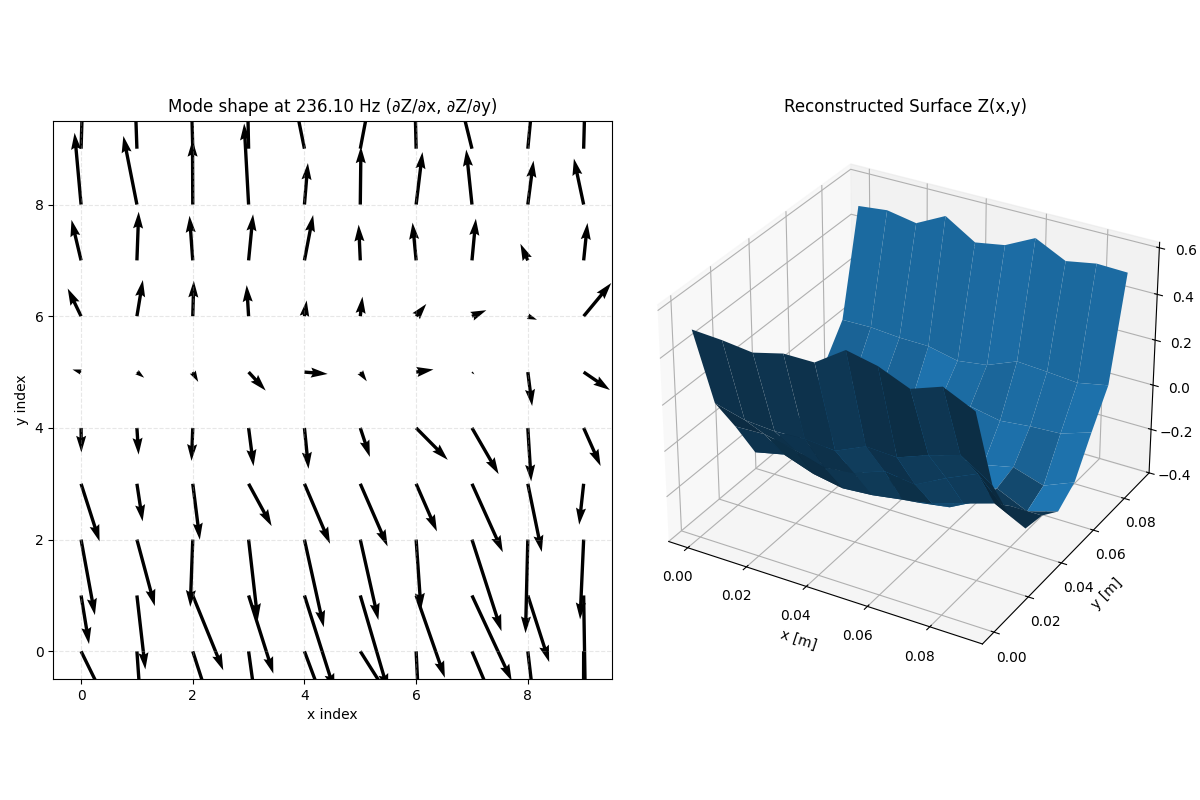

In [9]:
f0       = 236.1 # Hz
n_points = 10
D        = 0.01

import numpy as np

def reconstruct_surface_from_gradients(
    DX: np.ndarray,
    DY: np.ndarray,
    dx: float = 1.0,
    dy: float = 1.0,
    smoothing_lambda: float | None = None,
    smoothing_length: float | None = None,
    zero_mean: bool = True,
) -> np.ndarray:
    """
    Reconstruct a REAL surface Z[x,y] from REAL partial derivatives:
        DX = ∂Z/∂x  (axis-0),  DY = ∂Z/∂y  (axis-1),
    on a uniform grid using the Frankot–Chellappa method.

    Solves in Fourier domain (periodic BCs) the LS problem:
        minimize_Z ||DX - ∂Z/∂x||^2 + ||DY - ∂Z/∂y||^2  (+ optional Tikhonov on Z)

    Closed form:
        Ẑ(kx,ky) = ( i kx D̂X + i ky D̂Y ) / ( kx^2 + ky^2 + λ^2 )

    Parameters
    ----------
    DX, DY : (Nx, Ny) real arrays
        Spatial derivatives sampled on a rectangular, uniform grid.
        Axis-0 ↔ x, axis-1 ↔ y.
    dx, dy : float
        Grid spacings along x and y (same units as Z coordinates).
    smoothing_lambda : float or None
        Optional Tikhonov (screened Poisson) strength λ [radians per unit length].
        Larger λ ⇒ smoother Z. If None and `smoothing_length` is given, λ = 2π/ℓ.
    smoothing_length : float or None
        Convenience alternative to set λ via a physical length scale ℓ.
    zero_mean : bool
        If True, remove the mean of Z (height offset is undetermined anyway).

    Returns
    -------
    Z : (Nx, Ny) real array
        Reconstructed surface.
    """
    if DX.shape != DY.shape:
        raise ValueError("DX and DY must have the same shape (Nx, Ny).")
    if not (np.isrealobj(DX) and np.isrealobj(DY)):
        raise ValueError("DX and DY must be real arrays.")

    DX = np.asarray(DX, dtype=np.float64)
    DY = np.asarray(DY, dtype=np.float64)
    Nx, Ny = DX.shape

    # Angular spatial frequencies consistent with numpy FFTs
    kx = 2.0 * np.pi * np.fft.fftfreq(Nx, d=dx)[:, None]   # (Nx, 1)
    ky = 2.0 * np.pi * np.fft.fftfreq(Ny, d=dy)[None, :]   # (1, Ny)

    # FFT of gradients
    DX_hat = np.fft.fft2(DX)
    DY_hat = np.fft.fft2(DY)

    # Smoothing λ (screened Poisson)
    if smoothing_lambda is None:
        if smoothing_length is not None and smoothing_length > 0:
            lam = 2.0 * np.pi / float(smoothing_length)
        else:
            lam = 0.0
    else:
        lam = float(smoothing_lambda)
        if lam < 0:
            raise ValueError("smoothing_lambda must be ≥ 0")

    denom = (kx**2 + ky**2)
    if lam > 0.0:
        denom = denom + lam**2

    # Avoid division by zero at DC; numerator is 0 there for consistent gradients
    denom = denom.astype(np.float64)
    denom[0, 0] = np.inf

    # Frankot–Chellappa least-squares solution
    Z_hat = (-1j * kx * DX_hat - 1j * ky * DY_hat) / denom
    #Z_hat = (1j * kx * DX_hat + 1j * ky * DY_hat) / denom
    Z_hat[0, 0] = 0.0  # fix the arbitrary constant height

    Z = np.fft.ifft2(Z_hat).real

    if zero_mean:
        Z -= Z.mean()

    return Z


if True:
    all_shifts_FFT = np.fft.rfft(all_shifts, axis=1)
    #mag = np.abs(rfft_vals)  # shape: (72, n_freq_bins)

    fs = run_opt['cam_params']['camera_FPS']
    n_pts = all_shifts.shape[1]
    freqs = np.fft.rfftfreq(n_pts, d=1.0 / fs)
    idx_f0 = np.argmin(np.abs(freqs - f0))
    print("Closest frequency:", freqs[idx_f0], "Hz (index:", idx_f0, ")")

    FFT_f0 = all_shifts_FFT[:,idx_f0]
    FFT_f0_norm = FFT_f0 * (np.conj(FFT_f0[0,0]) / np.abs(FFT_f0[0,0]))

    x_coords, y_coords = np.meshgrid(np.arange(n_points), np.arange(n_points))
    U = np.real(FFT_f0_norm[:, 0]).reshape(n_points, n_points)
    V = np.real(FFT_f0_norm[:, 1]).reshape(n_points, n_points)

    Z = reconstruct_surface_from_gradients(U.T, V.T, dx=D, dy=D, smoothing_length=0.1,zero_mean=True)
   # Compute magnitude of all vectors (for auto quiver scaling)
    magnitudes = np.sqrt(U**2 + V**2)
    max_len = np.max(magnitudes)
    desired_frac = 0.2
    scale_auto = max_len / desired_frac

    # Coordinates for plotting (index grid and metric grid)
    X_m = x_coords * D
    Y_m = y_coords * D

    fig = plt.figure(figsize=(12, 8))

    # --- (1,2,1): Quiver of gradients (mode shape) ---
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.quiver(x_coords, y_coords, U, V, scale=scale_auto)
    ax1.set_title(f"Mode shape at {f0:.2f} Hz (∂Z/∂x, ∂Z/∂y)")
    ax1.set_xlim(-0.5, n_points - 0.5)
    ax1.set_ylim(-0.5, n_points - 0.5)
    ax1.set_aspect('equal', adjustable='box')
    ax1.set_xlabel('x index')
    ax1.set_ylabel('y index')
    ax1.grid(True, linestyle='--', alpha=0.3)

    # --- (1,2,2): 3D surface of Z(x,y) ---
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    # If you prefer millimeters, use (Z*1e3) and label accordingly.
    surf = ax2.plot_surface(X_m, Y_m, Z.T, rstride=1, cstride=1,
                            linewidth=0, antialiased=True, shade=True)
    ax2.set_title("Reconstructed Surface Z(x,y)")
    ax2.set_xlabel('x [m]')
    ax2.set_ylabel('y [m]')
    ax2.set_zlabel('Z [m]')
    # Nice viewing angle + roughly equal aspect
    ax2.view_init(elev=30, azim=-60)

    plt.tight_layout()
    plt.show()